# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de pulsos muy cortos de duración τ y un periodo de escucha mayor Τ para luego leer el reflejo del mismo en alguna superficie. La distancia al objetivo se determina por el tiempo de ida y vuelta de la señal (en el caso estacionario) generando un Δ$t$, lo que nos permite utilizar la siguiente fómula:
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.31"
SamplingRate     = 6e6        # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 0          # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 930e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30          # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 6e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize     = 2**20-1

In [2]:
import adi
import time
import sys
import timeit
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import threading
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth

In [3]:
Uri2              = "ip:192.168.1.32"
SamplingRate2     = 6e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback2         = 0            # 0=Disabled, 1=Digital, 2=RF

TxLOFreq2         = 930e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten2          = -30         # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw2           = 6e6          # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq2         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes2 = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain2   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw2           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize2     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:
  
$Max Range = \frac{c}{2}*PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [4]:
PRI = 0.001 #Se trata de un valor arbitrario, intervalo cada cuánto se repite el pulso (entre el inicio de un pulso y su antecesor)
PRF = 1/PRI #cantidad de pulsos por unidad de tiempo
potencia_señal = 1

pulses = 100 #cantidad de pulsos del radar

sample_f = SamplingRate
step = 1/SamplingRate #paso entre las muestras
f1 = 500e3
samples = pulses*int(PRI/step) # PRI/step cantidad de muestras que necesito para un PRI.

En esta porción de código calculamos la cantidad de $samples$ que vamos a utilizar, se obtiene de la división entre el intervalo de la repetición de pulsos y el paso entre las muestras, esto nos da la cantidad de muestras por pulso, luego, al multiplicarlo por la cantidad de pulsos del radar obtenemos la cantidad de muestras.

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi.


\begin{equation}
    Tx = \Pi(t) + \Pi(t)*j
\end{equation}



In [5]:
t = np.linspace(0,(samples-1)*step,samples) #Genera el array de valores de tiempo (600.000 valores separados cada <step> unidades de tiempo)
pulse_length = 0.0000004#[s]
global zeros
zeros = np.zeros(len(t))  # arreglo completo
ones = np.ones(int(pulse_length*SamplingRate)) # señal continua de duracion pulse_length

for i in range(0,len(t),int(PRI*SamplingRate)):
      zeros[i:i+len(ones)] = ones #Cada un PRI, hacemos a la función zeros igual a 1 durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos)

zerosOG = zeros +1j*zeros

/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


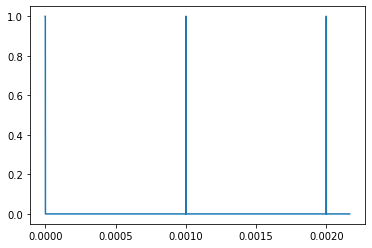

In [6]:
Tx = zerosOG
plt.plot(t[:13000],Tx[:13000])

In [7]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = True
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

Exception: No device found

In [ ]:
#-----------------------------------SDR Configurations-------------------------------
sdr2             = adi.Pluto(Uri2)
sdr2.sample_rate = SamplingRate2
sdr2.loopback    = Loopback2
#Tx:
sdr2.tx_lo                 = int(TxLOFreq2)
sdr2.tx_hardwaregain_chan0 = TxAtten2
sdr2.tx_rf_bandwidth       = int(TxRfBw2)
sdr2.tx_buffer_size        = samples
sdr2.tx_cyclic_buffer      = True
# Rx:
sdr2.rx_lo                   = int(RxLOFreq2)
sdr2.gain_control_mode_chan0 = GainControlModes2
sdr2.rx_rf_bandwidth         = int(RxRfBw2)
sdr2.rx_cyclic_buffer        = True
sdr2.rx_buffer_size          = RxBufferSize2
sdr2.rx_enabled_channels = [0]

Tramisión y Recepción

In [ ]:
Loopback        = 0 
sdr.loopback    = Loopback
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()
sdr2.tx_destroy_buffer()
sdr2.rx_destroy_buffer()
global picture
global rxSignal
global rxSignalPic
global zeros
global zerosPic
global tim1
global tim2

# Función para la transmisión en un hilo
def transmitir():
    global tim1
    global tim2
    sdr.tx(Tx * ((2**15-1)))
    tim1 = time.time()
    sdr2.tx(Tx*0.6* ((2**15-1)))
    tim2 = time.time()
    auxTim = ((tim2-tim1)/PRI)%1
    print(auxTim)

# Función para la recepción en un hilo
def recibir1():
    global rxSignal
    rxSignal = sdr.rx() / ((2**15-1)) 

def transmitir2():
    while True:
        sdr2.rx()/(2**15-1)

   
# Crea los hilos
thread_tx = threading.Thread(target=transmitir)
#thread_tx2 = threading.Thread(target=transmitir2)      
thread_rx1 = threading.Thread(target=recibir1)

#thread_tx2.start()
thread_tx.start()
thread_rx1.start()
          
# Espera a que los hilos terminen
thread_tx.join()
#thread_tx2.join()
thread_rx1.join()    

Luego de transmitir la señal, utilizamos la antena receptora para hacer la lectura correspondiente del pulso reflejado. En este caso tomamos de a 50 muestras de la señal reflejada guardadas en una matriz con 10 filas y n columnas, siendo n igual a la cantidad de muestras que hay en un determinado pulso (equivalente al tiempo PRI).

Ambas señales se escalan por (2^15)-1, ya que la SDR espera valores entre -(2^15-1) y (2^15-1)

In [ ]:
global rxSignal

zeros = zerosOG
def modificar_arreglo(arr):
    maximo_valor = max(arr)  # Calcula el máximo valor en el arreglo
    umbral = 0.3 * maximo_valor  # Establece el umbral al 60% del máximo

    # Modifica el arreglo, estableciendo a 0 los valores mayores al 60% del máximo
    nuevo_arreglo = [0 if valor < umbral else valor for valor in arr]

    return nuevo_arreglo


rxSignalPic = sdr.rx() / ((2**15-1))
rxSignalPicOG = rxSignalPic
#rxSignalPic = rxSignalPic


#desplazas zeros timestamp2-timestamp1
rows, cols = (pulses, int(PRI*SamplingRate)) #cantidad de pulsos recibidos y cantidad de muestras en cada pulso
recieved_signal = [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
    recieved_signal[i] = rxSignal[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)] #cada fila es un pulso, cada columna una muestra del pulso

size = 15000
#rxSignalRectifed = np.maximum(rxSignalPic, 0)
rxSignalRectifed = np.abs(rxSignalPic)

rxSignalRectifed = modificar_arreglo(rxSignalRectifed)
# Frecuencia de corte deseada en Hz
corte_deseado = 10000# 100 kHz

# Frecuencia de muestreo de la señal
fs = SamplingRate # inserta tu frecuencia de muestreo aquí

# Calcula la frecuencia de corte normalizada
fc_normalizada = corte_deseado / (0.5 * fs)

rp = 3  # máxima ondulación en la banda de paso en dB
order = 4  # orden del filtro

# Diseña el filtro Chebyshev tipo I
b, a = signal.cheby1(order, rp, fc_normalizada, btype='low')

# Coeficientes del filtro pasa bajos
#b, a = signal.butter(4, fc_normalizada, btype='low')

# Aplica el filtro a la señal demodulada
demodulated_signal_filtered = signal.lfilter(b, a, rxSignalRectifed)


#demodulated_signal_filtered = signal.lfilter([1], [1, -0.9], rxSignalRectifed)


# Visualización de la señal recibida
plt.figure(figsize=(10, 5))
plt.plot(t[0:60000],zeros[0:60000], label='Zeros Signal')
plt.plot(t[0:60000],rxSignalPic[0:60000], label='Rx Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()


# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
plt.plot(t[0:10000], rxSignalPic[0:10000], label='Rx Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()


# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[:10000], rxSignalRectifed[:10000], label='Rectified Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

#Matched filter used to maximize SNR ratio
def matched_filter(pulse,signal):
    #debo conjugar la señal o utilizar el pulso conjugado
    return np.convolve(pulse,signal,mode='full')

rows, cols = (pulses, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
       con[i] = matched_filter(zeros[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],rxSignalRectifed[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])

        

plt.xlabel('Tiempo')
plt.ylabel('Salida del Matched Filter')
plt.grid(True)
plt.plot(t[:len(con[8])],con[3][:len(con[9])])
#plt.plot(t[2000:3000],demodulated_signal_filtered[2000:3000])
plt.show()       

index_max_i = 0
index_max_w = 0
max_con_j = []
max_con_w = []
max_i = 0
aux = 0
for j in range(len(con[0])):
    if((con[i][j] > max_i)):
        max_i = con[0][j]
        index_max_i = j - int(pulse_length * SamplingRate)
        
aux = index_max_i + int(pulse_length/2 * SamplingRate)       
rxSignalRectifed = rxSignalRectifed[int(aux):]
#rxSignalRectifed = np.concatenate([rxSignalRectifed, np.zeros(int(aux))]) 
# Visualización de la señal demodulada
plt.figure(figsize=(10, 5))
plt.plot(t[0:20000], rxSignalRectifed[0:20000], label='Demodulated Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal Demodulada y Filtrada')
plt.grid(True)
plt.show() 
rows, cols = (pulses, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
       con[i] = matched_filter(zerosOG[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],rxSignalRectifed[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])
# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[0:50000],zeros[0:50000], label='Zeros Signal')
plt.plot(t[0:50000],zerosOG[0:50000], label='ZerosOG Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show() 


plt.xlabel('Tiempo')
plt.ylabel('Salida del Matched Filter')
plt.grid(True)
for j in range(pulses):
    plt.plot(t[:len(con[8])],con[j][:len(con[9])])
#plt.plot(t[2000:3000],demodulated_signal_filtered[2000:3000])
plt.show()  
       
index_max_i = 0
index_max_w = 0
max_con_j = []
max_con_w = []
max_val_j = []
max_val_w = []
for i in range(rows):
    max_i = 0
    for j in range(len(con[i])):
        if((con[i][j] > max_i)):
            max_i = con[i][j]
            index_max_j = j - int(pulse_length * SamplingRate)
    max_j = 0        
    for w in range((index_max_j + int(2*pulse_length * SamplingRate)),len(con[i])): 
        if((con[i][w] > max_j)):
            max_j = con[i][w]
            index_max_w = w - int(pulse_length * SamplingRate)
    
    
    max_con_j.append(index_max_j)
    max_val_j.append(max_i)
    max_con_w.append(index_max_w)# Guardar el índice en lugar del tiempo
    max_val_w.append(max_j)
    
if (np.median(max_val_j) < np.median(max_val_w)):
    print(np.median(max_val_j))
    print(np.median(max_val_w))
    print("ERROR")
    sys.exit()
    
    
# Calcular el delta time estimado
stimation_delta_t1_mediana = np.median(max_con_j) / SamplingRate
stimation_delta_t2_mediana = np.median(max_con_w) / SamplingRate
stimation_delta_t_mediana = stimation_delta_t2_mediana - stimation_delta_t1_mediana

stimation_delta_t1_media = np.mean(max_con_j) / SamplingRate
stimation_delta_t2_media = np.mean(max_con_w) / SamplingRate
stimation_delta_t_media = stimation_delta_t2_media - stimation_delta_t1_media

print("Tiempo delta estimado (MEDIANA): " + str(stimation_delta_t_mediana) + "[s]")
print("Tiempo delta estimado (MEDIA): " + str(stimation_delta_t_media) + "[s]")

# Calcular el rango estimado
stimation_range_mediana = stimation_delta_t_mediana * 299792458 / 2
stimation_range_media = stimation_delta_t_media * 299792458 / 2
print("Distancia estimada (MEDIANA): " + str(stimation_range_mediana) + "[m]")
print("Distancia estimada (MEDIA): " + str(stimation_range_media) + "[m]")



In [ ]:
global stimationMedian
global stimationMean
global stimationRealTime
global timTot
global picture
global rxSignal
global rxSignalPic
global zeros
global zerosPic
global tim1
global tim2
stimationMedian = []
stimationMean = []
stimationMedianPorcentaje = []

# Función para la transmisión en un hilo
def transmitir():
    global tim1
    global tim2
    global timTot
    sdr.tx(Tx * ((2**15-1)))
    tim1 = time.time()
    sdr2.tx(Tx * ((2**15-1)))
    tim2 = time.time()
    timTot = ((tim2 - tim1)/PRI)%1

# Función para la recepción en un hilo
def recibir1():
    global rxSignal
    rxSignal = sdr.rx() / ((2**15-1)) 

def modificar_arreglo(arr):
    maximo_valor = max(arr)  # Calcula el máximo valor en el arreglo
    umbral = 0.3 * maximo_valor  # Establece el umbral al 60% del máximo
    # Modifica el arreglo, estableciendo a 0 los valores mayores al 60% del máximo
    nuevo_arreglo = [0 if valor < umbral else valor for valor in arr]
    return nuevo_arreglo

lenght = 1000

for l in range(lenght):
    sdr.rx_destroy_buffer()
    sdr.tx_destroy_buffer()
    sdr2.tx_destroy_buffer()
    
    # Crea los hilos
    thread_tx = threading.Thread(target=transmitir)
    thread_rx1 = threading.Thread(target=recibir1)

    thread_tx.start()
    thread_rx1.start()

    # Espera a que los hilos terminen
    thread_tx.join()
    thread_rx1.join()    
    
    if (timTot > 4e-4):
        global rxSignal
    
        zeros = zerosOG
    
        rxSignalPic = sdr.rx() / ((2**15-1))
        rxSignalPicOG = rxSignalPic
    
        rows, cols = (pulses, int(PRI*SamplingRate)) #cantidad de pulsos recibidos y cantidad de muestras en cada pulso
        recieved_signal = [[0 for i in range(cols)] for j in range(rows)]
        for i in range(rows):
            recieved_signal[i] = rxSignal[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)] #cada fila es un pulso, cada columna una muestra del pulso
    
        size = 15000
        #rxSignalRectifed = np.maximum(rxSignalPic, 0)
        rxSignalRectifed = np.abs(rxSignalPic)
    
        rxSignalRectifed = modificar_arreglo(rxSignalRectifed)
        # Frecuencia de corte deseada en Hz
        corte_deseado = 10000# 100 kHz
    
        # Frecuencia de muestreo de la señal
        fs = SamplingRate # inserta tu frecuencia de muestreo aquí
    
        # Calcula la frecuencia de corte normalizada
        fc_normalizada = corte_deseado / (0.5 * fs)
    
        rp = 3  # máxima ondulación en la banda de paso en dB
        order = 4  # orden del filtro
    
        # Diseña el filtro Chebyshev tipo I
        b, a = signal.cheby1(order, rp, fc_normalizada, btype='low')
    
        # Coeficientes del filtro pasa bajos
        #b, a = signal.butter(4, fc_normalizada, btype='low')
    
        # Aplica el filtro a la señal demodulada
        demodulated_signal_filtered = signal.lfilter(b, a, rxSignalRectifed)
    
        #Matched filter used to maximize SNR ratio
        def matched_filter(pulse,signal):
            #debo conjugar la señal o utilizar el pulso conjugado
            return np.convolve(pulse,signal,mode='full')
    
        rows, cols = (pulses, int(PRI/step))
        con =  [[0 for i in range(cols)] for j in range(rows)]
        for i in range(rows):
               con[i] = matched_filter(zeros[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],rxSignalRectifed[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])
    
        index_max_i = 0
        index_max_w = 0
        max_con_j = []
        max_con_w = []
        max_i = 0
        aux = 0
        for j in range(len(con[0])):
            if((con[i][j] > max_i)):
                max_i = con[0][j]
                index_max_i = j - int(pulse_length * SamplingRate)
    
        aux = index_max_i + int(pulse_length/2 * SamplingRate)       
        rxSignalRectifed = rxSignalRectifed[int(aux):]
        rxSignalRectifed = np.concatenate([rxSignalRectifed, np.zeros(int(aux))]) 
        # Visualización de la señal demodulada
        rows, cols = (pulses, int(PRI/step))
        con =  [[0 for i in range(cols)] for j in range(rows)]
        for i in range(rows):
               con[i] = matched_filter(zerosOG[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],rxSignalRectifed[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])
    
        index_max_i = 0
        index_max_w = 0
        max_con_j = []
        max_con_w = []
        max_val_j = []
        max_val_w = []
        for i in range(rows):
            max_i = 0
            for j in range(len(con[i])):
                if((con[i][j] > max_i)):
                    max_i = con[i][j]
                    index_max_j = j - int(pulse_length * SamplingRate)
            max_j = 0        
            for w in range((index_max_j + int(2*pulse_length * SamplingRate)),len(con[i])): 
                if((con[i][w] > max_j)):
                    max_j = con[i][w]
                    index_max_w = w - int(pulse_length * SamplingRate)
    
    
            max_con_j.append(index_max_j)
            max_val_j.append(max_i)
            max_con_w.append(index_max_w)# Guardar el índice en lugar del tiempo
            max_val_w.append(max_j)
    
        # Calcular el delta time estimado
        stimation_delta_t1_mediana = np.median(max_con_j) / SamplingRate
        stimation_delta_t2_mediana = np.median(max_con_w) / SamplingRate
        stimation_delta_t_mediana = stimation_delta_t2_mediana - stimation_delta_t1_mediana
        stimationMedian.append(((stimation_delta_t_mediana/PRI) - timTot))
        
    
    
        stimation_delta_t1_media = np.mean(max_con_j) / SamplingRate
        stimation_delta_t2_media = np.mean(max_con_w) / SamplingRate
        stimation_delta_t_media = stimation_delta_t2_media - stimation_delta_t1_media
        stimationMean.append(((stimation_delta_t_media/PRI)-timTot))
    
    
        print("Tiempo delta estimado (MEDIANA): " + str(stimation_delta_t_mediana / PRI) + "[s]")
        print("Tiempo estimado Real: "+str(timTot))
        print("Diferencia entre estimacion y real: " + str((stimation_delta_t_mediana/PRI) - timTot))
        if((stimation_delta_t_mediana/PRI) > timTot):
            aux2 = abs((timTot/(stimation_delta_t_mediana/PRI))-1)*100
            print("Diferencia entre estimacion y real (PORCENTAJE): " + str(aux2))
            if(aux2 < 70):
                stimationMedianPorcentaje.append(aux2)
        else:
            aux3 = abs(((stimation_delta_t_mediana/PRI)/timTot)-1)*100
            print("Diferencia entre estimacion y real (PORCENTAJE): " + str(aux3))
            if(aux3 < 70):
                stimationMedianPorcentaje.append(aux3)
            
        #print("Tiempo delta estimado (MEDIA): " + str(stimation_delta_t_media) + "[s]")
    
        # Calcular el rango estimado
        stimation_range_mediana = stimation_delta_t_mediana * 299792458 / 2
        stimation_range_media = stimation_delta_t_media * 299792458 / 2
        #print("Distancia estimada (MEDIANA): " + str(stimation_range_mediana) + "[m]")
        #print("Distancia estimada (MEDIA): " + str(stimation_range_media) + "[m]")
        print(l)

    

Tiempo delta estimado (MEDIANA): 0.23066666666666666[s]
Tiempo estimado Real: 0.30502891540527344
Diferencia entre estimacion y real: -0.07436224873860678
Diferencia entre estimacion y real (PORCENTAJE): 24.378753942001254
0
Tiempo delta estimado (MEDIANA): 0.37999999999999995[s]
Tiempo estimado Real: 0.3798198699951172
Diferencia entre estimacion y real: 0.00018013000488276143
Diferencia entre estimacion y real (PORCENTAJE): 0.04740263286387991
1
Tiempo delta estimado (MEDIANA): 0.8145[s]
Tiempo estimado Real: 0.8194637298583984
Diferencia entre estimacion y real: -0.004963729858398436
Diferencia entre estimacion y real (PORCENTAJE): 0.6057290490765421
2
Tiempo delta estimado (MEDIANA): 0.17416666666666666[s]
Tiempo estimado Real: 0.07965087890625
Diferencia entre estimacion y real: 0.09451578776041666
Diferencia entre estimacion y real (PORCENTAJE): 54.26743794856459
3
Tiempo delta estimado (MEDIANA): 0.30933333333333335[s]
Tiempo estimado Real: 0.35144805908203125
Diferencia entre e

La siguiente celda corresponde a 1000 corridas del programa para analizar la diferencia entre el tiempo estimado con el programa y el tiempo calculado mediante timestamps. Cabe aclarar que este valor suele ser de un 15% de media y 7,5% de mediana debido a la baja exactitud de los timestaps y al ruido. Se utiliza unicamente para demostrar que el modelo seria funcional en caso de contar con las distancias minimas permitidas por el ancho de pulso para medir un objeto real, al no ser esto posible se simula utilizando otra SDR.   
NOTA: HAY QUE INTENTAR UTILIZAR LOOPBACK RF PERO NO SE COMO FUNCIONA

In [ ]:

print("La media de error en porcentaje es: " + str(np.mean(stimationMedianPorcentaje)))
print("La mediana de error en porcentaje es: " + str(np.median(stimationMedianPorcentaje)))

plt.hist(stimationMedianPorcentaje, bins=len(stimationMedianPorcentaje), density=True, alpha=0.75, edgecolor='red')

# Personalizar el gráfico
plt.title('Diferencia en porcentaje')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.xlim(0,max(stimationMedianPorcentaje))
# Ajustar la resolución
plt.figure(dpi=300)

# Mostrar el histograma
plt.show()

plt.hist(stimationMedian, bins=len(stimationMedian), density=True, alpha=0.75, edgecolor='red')

# Personalizar el gráfico
plt.title('Diferencia en ')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.xlim(min(stimationMedian),max(stimationMedian))
# Ajustar la resolución
plt.figure(dpi=300)

# Mostrar el histograma
plt.show()

### Cálculo y estimación del rango
Haciendo uso de las 100 muestras tomadas, y de hacer pasar la señal recibida por el matched filter, es tiempo de calcular los distintos $\Delta t$ para cada muestra. Luego de hacer esto se calcula la media y se determina el valor estimado por el radar siguiendo la formula expresada anteriormente:
### <center> $R = \frac{\Delta t*c}{2}$

In [23]:

#Matched filter used to maximize SNR ratio
def matched_filter(pulse,signal):
    #debo conjugar la señal o utilizar el pulso conjugado
    return np.convolve(pulse,signal,mode='full')

rows, cols = (pulses, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
       con[i] = matched_filter(zeros[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],signalEliminada[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])

plt.xlabel('Tiempo')
plt.ylabel('Salida del Matched Filter')
plt.grid(True)
plt.plot(t[:len(con[8])],con[20][:len(con[9])])
#plt.plot(t[2000:3000],demodulated_signal_filtered[2000:3000])
plt.show()


NameError: name 'signalEliminada' is not defined

In [ ]:
index_max_j = 0
max_con = []

# Asumiendo que 'zeros' es el tren de pulsos "zeros"
for i in range(0, rows):
    max_i = 0
    for j in range(len(con[i])):
        if((con[i][j] > max_i) and (con[i][j] >= 0.05)):
            max_i = con[i][j]
            # Comparar con el tren de pulsos "zeros" en lugar de 't'
            index_max_j = j - int(pulse_length * SamplingRate)

    max_con.append(index_max_j)  # Guardar el índice en lugar del tiempo

# Calcular el delta time estimado
stimation_delta_t = sum(max_con) / len(max_con) / SamplingRate
print("Estimated delta time: " + str(stimation_delta_t) + "[s]")

# Calcular el rango estimado
stimation_range = stimation_delta_t * 299792458 / 2
print("Estimated range: " + str(stimation_range) + "[m]")


Podemos apreciar como empeora la estimacion de distancia cuando no se utiliza el filtro apareado pero si la misma tecnica del buscar el maximo


In [ ]:
#Delta time detector
#max = rxSignal[0]
index_max_j = 0
max_con = []
for i in range(rows):
    max_i = 0
    for j in range(len(recieved_signal[i])):
        if(recieved_signal[i][j]>max_i):
            max_i = con[i][j]
            index_max_j = j
    #print(index_max_j)
    max_con.append(t[index_max_j])

stimation_delta_t = sum(max_con)/len(max_con)
print("Stimated delta time: " + str(stimation_delta_t) + "[s]")
stimation_range = stimation_delta_t*299792458/2
print("Stimated range: " + str(stimation_range) + "[m]")

In [50]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
sdr.tx_hardwaregain_chan0 = -89 
sdr.tx_lo                 = int(2400e6)
sdr.rx_lo                 = int(950e6)
sdr.tx(np.zeros(2048))
# Destroy radio object
del(sdr)

# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr2.tx_destroy_buffer()
sdr2.tx_hardwaregain_chan0 = -89 
sdr2.tx_lo                 = int(2400e6)
sdr2.rx_lo                 = int(950e6)
sdr2.tx(np.zeros(2048))
# Destroy radio object
del(sdr2)

ERROR: Open unlocked: -16


OSError: [Errno 16] Device or resource busy